In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the data
data = pd.read_csv('/content/data (1).csv')

In [ ]:
dt = data.dtypes

In [ ]:
dt

timestamp       object
cpu_request    float64
dtype: object

In [ ]:
data.head(10)

,timestamp,cpu_request
0,01-05-2019 19:00,0.250000
1,01-05-2019 19:01,0.328090
2,01-05-2019 19:02,0.237440
3,01-05-2019 19:03,0.224980
4,01-05-2019 19:04,0.196928
5,01-05-2019 19:05,0.237510
6,01-05-2019 19:06,0.197808
7,01-05-2019 19:07,0.318098
8,01-05-2019 19:08,0.112460
9,01-05-2019 19:09,0.249998


In [ ]:
# any missing values?
data.isnull().values.any()

False

In [ ]:
#Check number of rows and columns, type of each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    4999 non-null   object 
 1   cpu_request  4999 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.2+ KB


In [ ]:
# Understanding the numeric fields
data.describe()

,cpu_request
count,4999.000000
mean,0.348226
std,0.124181
min,0.032487
25%,0.243690
50%,0.362440
75%,0.481110
max,0.875000


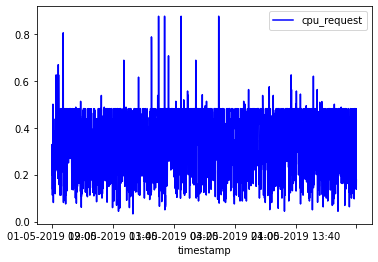

In [ ]:
ax = plt.gca()

data.plot(kind='line',x='timestamp',y='cpu_request', color='blue', ax=ax)

plt.show()

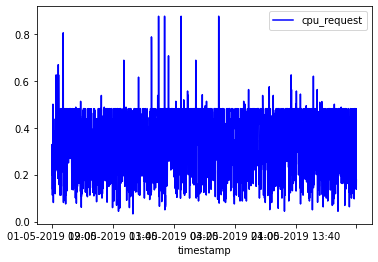

In [ ]:
ax = plt.gca()

data.plot(kind='line',x='timestamp',y='cpu_request', color='blue', ax=ax)

plt.show()

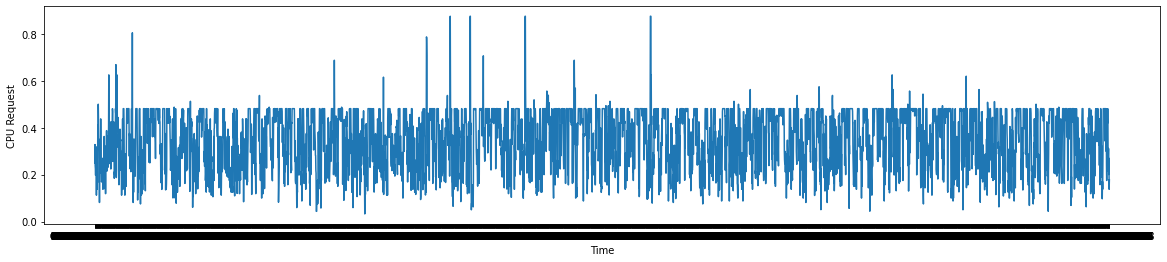

In [ ]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('CPU Request')
plt.plot(data.timestamp, data.cpu_request);

In [ ]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

test_stationarity(data.cpu_request)

In [ ]:
# first difference
data['diff'] = data['cpu_request'] - data['cpu_request'].shift(1)  
test_stationarity(data['diff'].dropna(inplace=False))

Test Statistic           -20.769868
p-value                    0.000000
Lags                      32.000000
Observations            4965.000000
Critical Value (1%)       -3.431668
Critical Value (5%)       -2.862122
Critical Value (10%)      -2.567080
dtype: float64


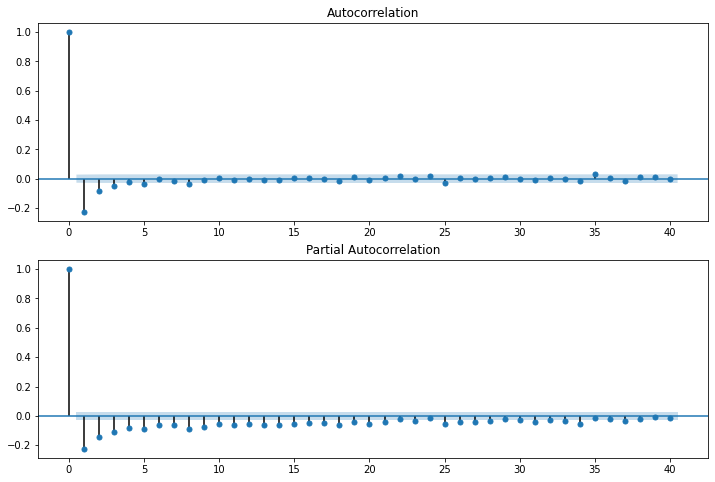

In [ ]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['diff'][1:], lags=40, ax=ax2)

In [ ]:
data.head

<bound method NDFrame.head of              timestamp  cpu_request      diff
0     01-05-2019 19:00     0.250000       NaN
1     01-05-2019 19:01     0.328090  0.078090
2     01-05-2019 19:02     0.237440 -0.090650
3     01-05-2019 19:03     0.224980 -0.012460
4     01-05-2019 19:04     0.196928 -0.028052
...                ...          ...       ...
4994  05-05-2019 06:14     0.311300  0.052501
4995  05-05-2019 06:15     0.200626 -0.110674
4996  05-05-2019 06:16     0.269385  0.068759
4997  05-05-2019 06:17     0.137486 -0.131899
4998  05-05-2019 06:18     0.177800  0.040314

[4999 rows x 3 columns]>

In [ ]:
data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            cpu_request   No. Observations:                 4998
Model:                     ARMA(1, 3)   Log Likelihood                4770.589
Method:                       css-mle   S.D. of innovations              0.093
Date:                Tue, 24 May 2022   AIC                          -9529.178
Time:                        04:50:49   BIC                          -9490.077
Sample:                             0   HQIC                         -9515.473
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3481      0.004     83.492      0.000       0.340       0.356
ar.L1.cpu_request     0.7119      0.027     26.733      0.000       0.660       0.764
ma.L1.cpu_request    -0.

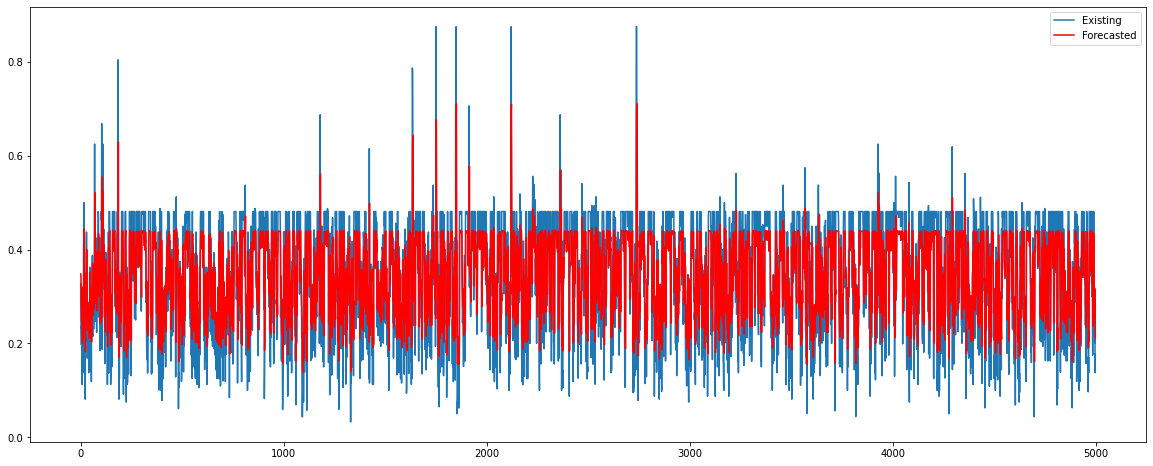

In [ ]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(data['cpu_request'], order=(1,0,3)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data['cpu_request'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Existing', 'Forecasted'])
print(results.summary())

**FORECASTING**

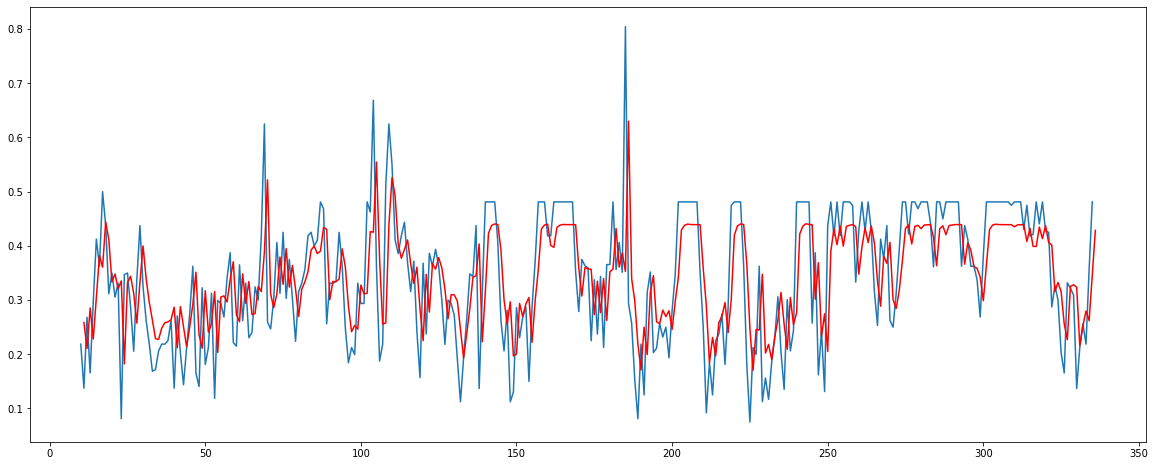

In [ ]:
# forecast quick and dirty
# TODO: clean this up
fig = plt.figure(figsize=(20,8))
num_points = len(data['cpu_request'])
#x = results.predict(start=(120), end=(135), dynamic=False)
#x = results.predict(start=(100), end=(435), dynamic=False)
x = results.predict(start=(10), end=(335), dynamic=False)
plt.plot(data['cpu_request'][9:335])
plt.plot(x, color='r')

In [ ]:
z = results.predict(start=(1), end=(10), dynamic=False)

In [ ]:
print(z)

2     0.334925
3     0.278632
4     0.265916
5     0.246149
6     0.269794
7     0.247260
8     0.320044
9     0.199312
10    0.274980
11    0.258650
dtype: float64


In [ ]:
df1 = pd.DataFrame(z, columns = ['Predicted_CPU_Request'])
print(df1)

    Predicted_CPU_Request
2                0.334925
3                0.278632
4                0.265916
5                0.246149
6                0.269794
7                0.247260
8                0.320044
9                0.199312
10               0.274980
11               0.258650


In [ ]:
y = data['cpu_request'][1:11]

In [ ]:
print(y)

2     0.237440
3     0.224980
4     0.196928
5     0.237510
6     0.197808
7     0.318098
8     0.112460
9     0.249998
10    0.218660
11    0.137460
Name: cpu_request, dtype: float64


In [ ]:
df2 = pd.DataFrame(y)
print(df2)

    cpu_request
2      0.237440
3      0.224980
4      0.196928
5      0.237510
6      0.197808
7      0.318098
8      0.112460
9      0.249998
10     0.218660
11     0.137460


In [ ]:
result = pd.concat([df1, df2], axis=1, join='inner')
display(result)

,Predicted_CPU_Request,cpu_request
2,0.334925,0.237440
3,0.278632,0.224980
4,0.265916,0.196928
5,0.246149,0.237510
6,0.269794,0.197808
7,0.247260,0.318098
8,0.320044,0.112460
9,0.199312,0.249998
10,0.274980,0.218660
11,0.258650,0.137460


In [ ]:
result['Val_Diff'] = result['Predicted_CPU_Request'] - result['cpu_request']

In [ ]:
display(result)

,Predicted_CPU_Request,cpu_request,Val_Diff
2,0.334925,0.237440,0.097485
3,0.278632,0.224980,0.053652
4,0.265916,0.196928,0.068988
5,0.246149,0.237510,0.008639
6,0.269794,0.197808,0.071986
7,0.247260,0.318098,-0.070838
8,0.320044,0.112460,0.207584
9,0.199312,0.249998,-0.050686
10,0.274980,0.218660,0.056320
11,0.258650,0.137460,0.121190


In [ ]:
result.loc[result['Val_Diff'] <= (0.2*result['cpu_request']), 'Resource_allocation_required'] = 'No'
result.loc[result['Val_Diff'] >= (0.2*result['cpu_request']), 'Resource_allocation_required'] = 'Yes'

In [ ]:
result

,Predicted_CPU_Request,cpu_request,Val_Diff,Resource_allocation_required
2,0.334925,0.237440,0.097485,Yes
3,0.278632,0.224980,0.053652,Yes
4,0.265916,0.196928,0.068988,Yes
5,0.246149,0.237510,0.008639,No
6,0.269794,0.197808,0.071986,Yes
7,0.247260,0.318098,-0.070838,No
8,0.320044,0.112460,0.207584,Yes
9,0.199312,0.249998,-0.050686,No
10,0.274980,0.218660,0.056320,Yes
11,0.258650,0.137460,0.121190,Yes


In [ ]:
#Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(data['cpu_request'].head(326), x)))

0.14423283476732848


In [ ]:
#mean squared error
print(mean_squared_error(data['cpu_request'].head(326), x))

0.02080311062501948


In [ ]:
#r2 score
from sklearn.metrics import r2_score
r2_score(data['cpu_request'].head(326), x)

-0.42154693892411244

In [ ]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(data['cpu_request'].head(326), x)
print('Test MAE: %.3f' % mae)

Test MAE: 0.114


In [ ]:
#mean percentage error
mpe_sum = 0
for i,j in zip(data['cpu_request'].head(326), x):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/x)*100
print('Test MPE')
print(mpe)


Test MPE
11    -25365.001596
12    -31134.076761
13    -22990.780568
14    -28768.109311
15    -21432.597707
           ...     
332   -25999.765344
333   -23432.675251
334   -25051.061631
335   -19017.422077
336   -15309.555079
Length: 326, dtype: float64


In [ ]:
#mean absolute percentage error
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(data['cpu_request'].head(326), x)*100
print(mape)

11.394788942973715


In [ ]:
#Normalized root mean square deviation
from statistics import *
RMSE=sqrt(mean_squared_error(data['cpu_request'].head(326), x))
NRMSE = RMSE/mean (x)
print(NRMSE)

0.42088471072709094
